Since I cannot install the OpenPose on my local machine nor the clusters. I have to use the Google Colab to generate the video.

# Detecting Gait Gesture with OpenPose

The code for the following notebook is modified based on [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).

## Install OpenPose

In [1]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

Selecting previously unselected package libgflags2.2.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

## Download a sample Korean sign language video

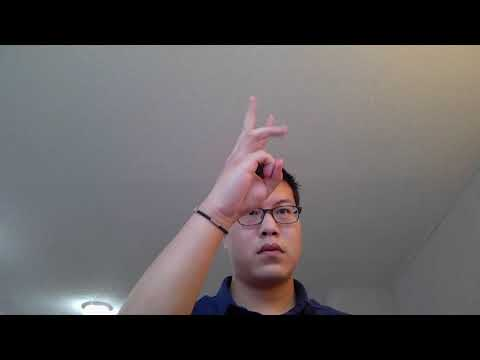

In [2]:
KSL_ID = 'yGrp_dDox8E'
YouTubeVideo(KSL_ID)

After downloading the video, process it through openpose.
By default CMU openpose does not annotate face and hand poses. To include them, add '--hand --face' as shown below:

`./build/examples/openpose/openpose.bin --face --hand --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi`

For details on how to use openpose, refer to the [openpose github](https://github.com/CMU-Perceptual-Computing-Lab/openpose#quick-start-overview)

The output is in *.avi format so convert it into *.mp4 for easy processing. The conversion can be done through ffmpeg.

Two outputs are specified.
- --write_json: write the auto-annotation results to a json file. For each frame of the video, one json file will be generated.
- --write_video: writes a video that includes the pose annotations

In [3]:
def download_youtube(youtube_id, start_time=10, duration=5):
  !rm -rf clip*.mp4
  !rm -rf openpose/output/*
  # # download the youtube with the given ID
  !youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$youtube_id
  # just pick a section where sign language is done
  !ffmpeg -y -loglevel info -ss $start_time -t $duration -i youtube.mp4 clip.mp4
  # # detect poses on the these 10 seconds
  !rm openpose.avi
  !cd openpose && ./build/examples/openpose/openpose.bin --face --hand --video ../clip.mp4 --write_json ./output_json/ --display 0  --write_video ../clip_openpose.avi
  # convert the result into MP4
  !ffmpeg -y -loglevel info -i clip_openpose.avi clip_openpose.mp4

download_youtube(KSL_ID)

[youtube] yGrp_dDox8E: Downloading webpage
[youtube] yGrp_dDox8E: Downloading MPD manifest
[download] Destination: youtube.mp4
[download] 100% of 1.70MiB in 00:37
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-li

Download the above youtube video, cut the first 10 seconds and do the pose detection on that 10 seconds:

Finally, visualize the result:

## Visualize the result

### video
Openpose outputs a video file that contains superimposed keypoint annotations. Let's first see how we can visualize it.

In [4]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('clip_openpose.mp4', width=960, height=720)

### images
Under the hood, openpose splits the video into individual frames and auto-annotate each image. To see the detailed output, we can use ffmpeg to see how the video is split into different frame images.

The command to do that is:

`-vf fps=30`

To make the output filenames easy to trace, let's format the numbered output file names by padding them with five zeroes.
`./images/out%05.png`

## Convert the video into frame images

In [5]:
!rm openpose/images/video_out*.png
!mkdir openpose/output_images/
!cd openpose && ffmpeg -ss 10 -t 5 -i ../youtube.mp4 ./output_images/out%05d.png -vf fps=30

rm: cannot remove 'openpose/images/video_out*.png': No such file or directory
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --

# Visualize key points on images

In [6]:
import cv2
import glob
import json
import numpy as np
import os

from matplotlib import pyplot as plt

def load_images(path):
    path = os.path.join(path,'*')
    files = glob.glob(path)
    # We sort the images in alphabetical order to match them
    #  to the annotation files
    files.sort()

    X_raw = []
    for file in files:
        image = cv2.imread(file)
        X_raw.append(np.array(image))

    return X_raw
        
def from_json(path):
    """
    save json data to path
    """
    file = open(path, 'r', encoding='utf-8')
    return json.load(file)

def extract_openpose_anns(ann_json):
  def extract_keypoints(ann_json):
    X = []
    Y = []
    C = []
    id = 0
    while id < len(ann_json):
      if ann_json[id] != 0:
        X.append(ann_json[id])
        Y.append(ann_json[id+1])
        C.append(ann_json[id+2])
        id += 3
      else:
        id += 1
  
    return np.array([X, Y, C])

  kp_pose = extract_keypoints(ann_json['people'][0]['pose_keypoints_2d'])
  kp_face = extract_keypoints(ann_json['people'][0]['face_keypoints_2d'])
  kp_hand_left = extract_keypoints(ann_json['people'][0]['hand_left_keypoints_2d'])
  kp_hand_right = extract_keypoints(ann_json['people'][0]['hand_right_keypoints_2d'])

  pose = {}
  pose['pose'] = kp_pose
  pose['face'] = kp_face
  pose['hand_left'] = kp_hand_left
  pose['hand_right'] = kp_hand_right

  return pose

def extract_pose_annotations(path):
  path = os.path.join(path,'*')
  files = glob.glob(path)
  files.sort()

  Y_raw = []
  for file in files:
    ann_json = from_json(file)
    ann = extract_openpose_anns(ann_json)
    Y_raw.append(ann)

  return Y_raw

## Load the images and key point files
Having defined the methods, let's load the images and the key point annotation files.

In [7]:
X_raw = load_images("openpose/output_images/")
len(X_raw)

138

In [8]:
Y_raw = extract_pose_annotations("openpose/output_json/")
len(Y_raw)

138

## Plot images with key points

Finally, load and plot the images with key points.

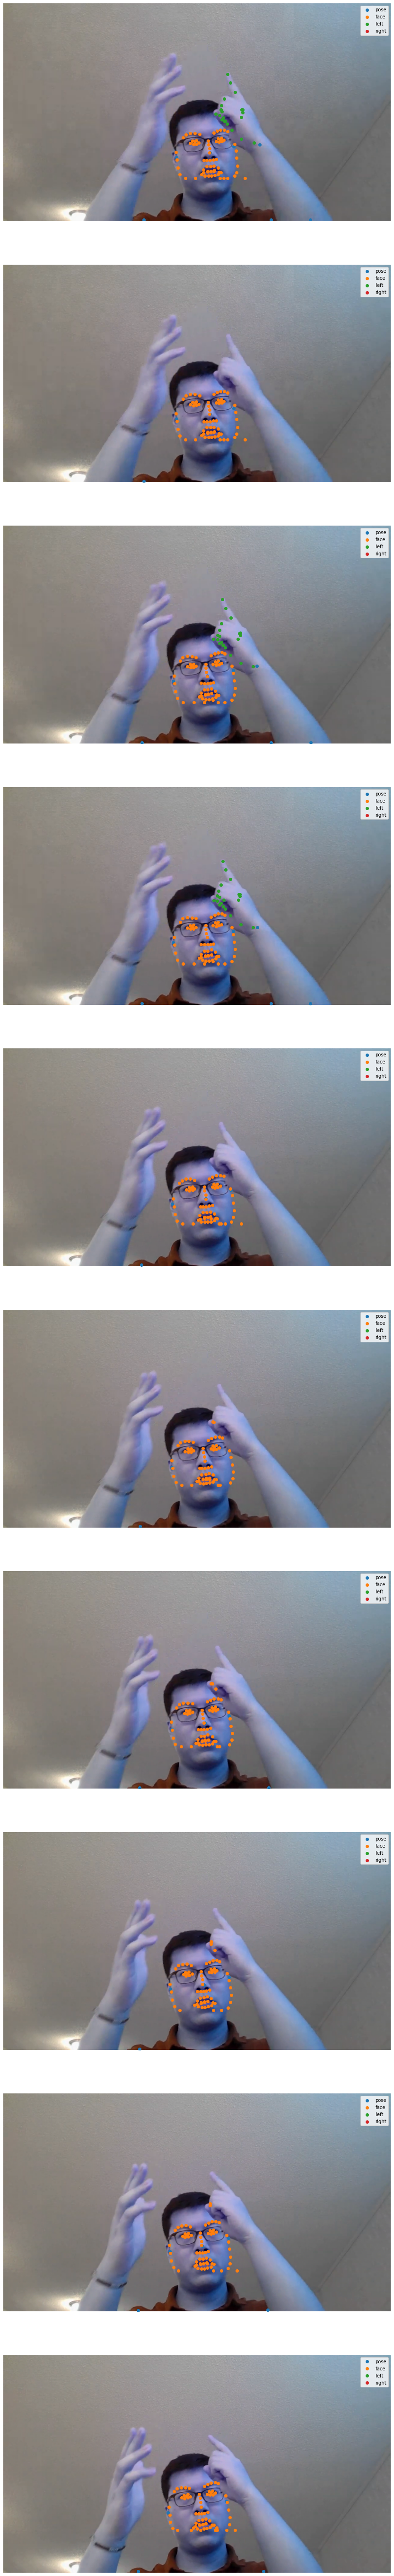

In [11]:
import matplotlib.pyplot as plt

def plot_pose(X, Y, start_id=0, end_id=10):
  # fig, ax = plt.subplots()
  fig = plt.figure(figsize=(100, 100))

  for id in range(start_id, end_id):
    x = X[id]
    y = Y[id]

    ax = fig.add_subplot(10, 1, id - start_id + 1)
    plt.axis('off')

    ax.imshow(x)

    ax.scatter(y['pose'][0], y['pose'][1], label='pose')
    ax.scatter(y['face'][0], y['face'][1], label='face')
    ax.scatter(y['hand_left'][0], y['hand_left'][1], label='left')
    ax.scatter(y['hand_right'][0], y['hand_right'][1], label='right')
    ax.legend()

  # ax.invert_yaxis()

plot_pose(X_raw, Y_raw)